# Data Challenge 7 — Evaluating SLR, Assumptions, & the Bias–Variance Tradeoff

**Goal:** Fit a simple linear regression (SLR) with a **train–test split**, report **MAE/RMSE** on *unseen* data, and use **training residuals** to check assumptions. Explain **bias vs. variance** in plain English.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple* — minimal coercion for chosen columns only.

## We Do — Instructor Session (20 mins)
Use this **step-by-step plan** to guide students. Keep it high-level; they will implement in the *You Do* section.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (attributes like `resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.
2) **Assign Y and X (one predictor)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one-liner** → MAE/RMSE in units + brief reliability note.


## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [1]:
# import packages
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [2]:
# Read in data and look at it!

df = pd.read_csv("/Users/kabbo/Downloads/2023_Yellow_Taxi_Trip_Data_20251015.csv", low_memory=False)
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10,5.0,0.5,0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3,0.0,1.0,31.4,2.5,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,3.310907e+06,3.133527e+06,3.133527e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.133527e+06,3.133527e+06
mean,1.750368e+00,1.409560e+00,1.784972e+00,1.650685e+02,1.639182e+02,1.168633e+00,1.485240e+00,4.828656e-01,5.734011e-01,9.758456e-01,2.270032e+00,1.367974e-01
std,4.356449e-01,9.117169e-01,8.283274e+00,6.428330e+01,6.968454e+01,5.959677e-01,1.814139e+00,1.206643e-01,2.228458e+00,2.170912e-01,8.078364e-01,4.796868e-01
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-3.917000e+01,-5.000000e-01,-7.000000e+01,-1.000000e+00,-2.500000e+00,-1.750000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.500000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
max,6.000000e+00,9.000000e+00,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.168000e+01,4.217000e+01,1.613800e+02,1.000000e+00,2.500000e+00,1.750000e+00


### Step 1 & 2 — Read in the file and Choose **Y** (target) and **X** (one predictor)
- Keep them numeric and present in your CSV.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [3]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'trip_distance']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors="coerce"
)

Y = trip_distance
X = fare_amount

### Step 3 — Train–Test Split (80/20 random split for practice)

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Perform the Train-Test Split ---
# Prepare X data with constant
X = sm.add_constant(df['fare_amount'])  # independent variable(s)
y = df['trip_distance']                     # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")



Training data shape: (2648725, 2)
Testing data shape:  (662182, 2)


### Step 4 — Fit on TRAIN only; Evaluate on TEST
Compute **MAE** and **RMSE** in the **units of Y**.

In [6]:
# --- Train the model ONLY on the training data ---
model = sm.OLS(y_train, X_train).fit()

In [8]:
# --- Evaluate the model on the unseen testing data ---
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nMean Absolute Error (MAE) on Test Data: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.2f}")
print(f"\nInterpretation: Our model's predictions on new data are off by an average of ${mae*1000:,.2f}.")
            


Mean Absolute Error (MAE) on Test Data: 1.67
Root Mean Squared Error (RMSE) on Test Data: 224.61

Interpretation: Our model's predictions on new data are off by an average of $1,674.70.


### Step 5 — Diagnostic Plots (TRAIN residuals)
Check regression assumptions using **training** residuals.
- **Homoscedasticity:** random cloud around 0 (no cone).
- **Normality:** Q–Q plot ~ diagonal.

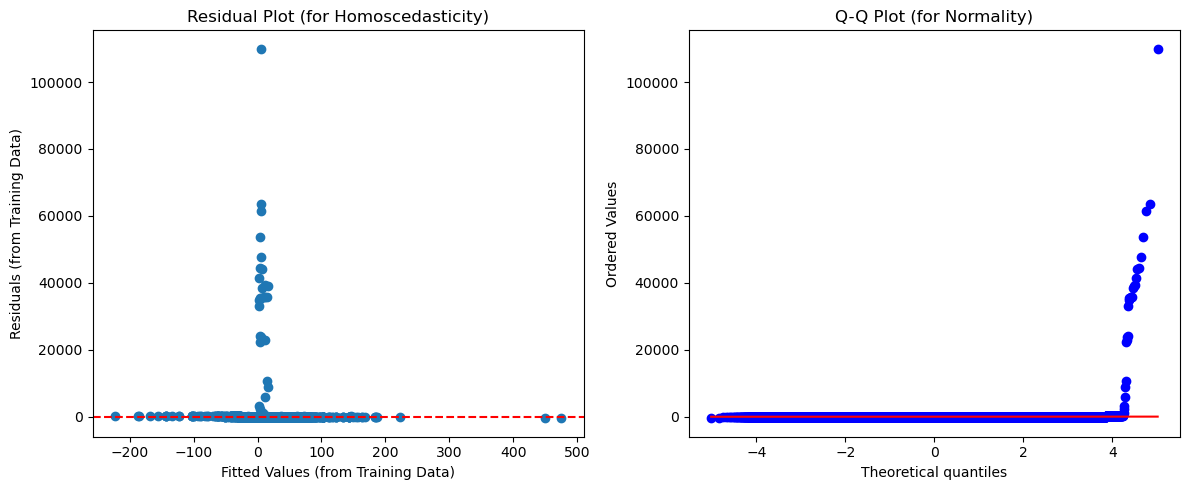

                            OLS Regression Results                            
Dep. Variable:          trip_distance   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2297.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:06:06   Log-Likelihood:            -1.6698e+07
No. Observations:             2648725   AIC:                         3.340e+07
Df Residuals:                 2648723   BIC:                         3.340e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3785      0.117     -3.237      

In [7]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- Check assumptions using the training data model ---
# Residuals from the model trained on X_train, y_train
train_residuals = model.resid 

# 1. Plot for Homoscedasticity
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

# 3. Durbin-Watson statistic is in the summary output below
print(model.summary())

### Step 6 — Quick Bias–Variance Read (optional)
Compare **train** and **test** errors and describe what you see.

## We Share — Reflection & Wrap‑Up
Write **1–2 short paragraphs** addressing:


1) **Is this model good enough** for a real decision **right now**? Why/why not?
Refer to **MAE/RMSE in units**, any **assumption issues**, and whether accuracy meets a reasonable business threshold.

        No. The model is still flawed and unusable. It has zero predictive power ($R^2$ is 0.001), and the huge gap between its MAE (1.67) and RMSE (224.61) shows it makes catastrophic errors.

2) **What’s your next move** to improve trust/accuracy?
Examples: adopt a **time‑aware split**, try a more relevant **X**, transform variables, segment checks (hour/zone), or move to **Multiple Linear Regression** with validation.

        Not quite sure. I would like to include more parameters. Like passenger count, PULocationID, and maybe feature engineer some columns. This might made the model more accurate.